<h2 align=center>Model Instllation</h2>

In [2]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 4090, done.
remote: Counting objects: 100% (4090/4090), done.
remote: Compressing objects: 100% (3091/3091), done.
remote: Total 4090 (delta 1184), reused 2007 (delta 937), pack-reused 0
Receiving objects: 100% (4090/4090), 44.63 MiB | 23.12 MiB/s, done.
Resolving deltas: 100% (1184/1184), done.


In [3]:
# Compile the Object Detection API protocol buffers
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

In [4]:
%%writefile models/research/setup.py

import os
from setuptools import find_packages
from setuptools import setup

REQUIRED_PACKAGES = [
    'tf-models-official==2.7.0',
    'tensorflow_io'
]

setup(
    name='object_detection',
    version='0.1',
    install_requires=REQUIRED_PACKAGES,
    include_package_data=True,
    packages=(
        [p for p in find_packages() if p.startswith('object_detection')] +
        find_packages(where=os.path.join('.', 'slim'))),
    package_dir={
        'datasets': os.path.join('slim', 'datasets'),
        'nets': os.path.join('slim', 'nets'),
        'preprocessing': os.path.join('slim', 'preprocessing'),
        'deployment': os.path.join('slim', 'deployment'),
        'scripts': os.path.join('slim', 'scripts'),
    },
    description='Tensorflow Object Detection Library',
    python_requires='>3.6',
)

Writing models/research/setup.py


In [5]:
# Run the setup script you just wrote
!python -m pip install models/research

Processing ./models/research
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 107.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 113.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 71.3 MB/s eta 0:00:00
  

<h1>Loading Images To Test</h1>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip -q /content/drive/MyDrive/Image-Segmentation-with-Mask-R-CNN-main/cities.zip

In [8]:
TEST_IMAGES = {
  'mitu_kaju_palki' : '/Mitu_Kaju_Palaki.jpeg',
  'berlin' : '/content/berlin.jpg',
  'budapest' : '/content/budapest.jpg',
  'gdansk' : '/content/gdansk.jpg',
  'krakow' : '/content/krakow.jpg',
  'olsztyn' : '/content/olsztyn.jpg',
  'oslo' : '/content/oslo.jpg',
  'prague' : '/content/prague.jpg',
  'warsaw_1' : '/content/warsaw.jpg',
  'warsaw_2' : '/content/warsaw_2.jpg',
}

<h2 align=center>Libraries</h2>

In [9]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
from six import BytesIO
from PIL import Image
from six.moves.urllib.request import urlopen

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

tf.get_logger().setLevel('ERROR')

%matplotlib inline

In [10]:
def load_image_into_numpy_array(path):
  image = None
  image_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(image_data))

  (im_width, im_height) = (image.size)
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

<h2 align=center>Load the Mask R-CNN Model</h2>

In [11]:
model_display_name = 'Mask R-CNN Inception ResNet V2 1024x1024'
model_handle = 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:Mask R-CNN Inception ResNet V2 1024x1024
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1


In [12]:
print('Loading model..')
start = time.time()
hub_model = hub.load(model_handle)
end = time.time()
cal_time = end - start
print("\nProcess took {} seconds.".format(cal_time))
print('Model loaded!')

Loading model..

Process took 39.16321778297424 seconds.
Model loaded!


In [13]:
image_path = TEST_IMAGES['krakow']

In [14]:
image_np = load_image_into_numpy_array(image_path)

<p>Plotting the image without segmentation.</p>

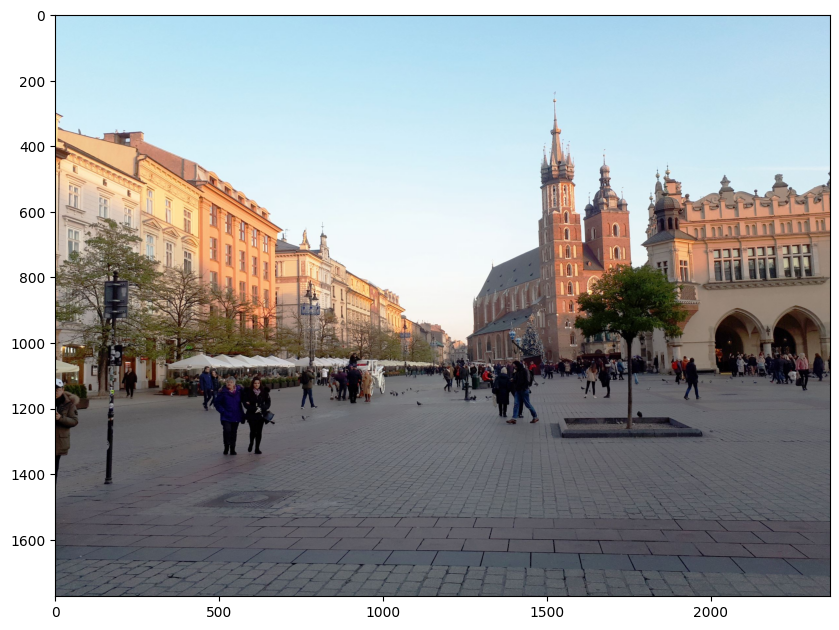

In [20]:
plt.figure(figsize=(10,15))
plt.imshow(image_np[0])
plt.show()

In [21]:
# Run inference
results = hub_model(image_np)

# output values are tensors and we only need the numpy()
# parameter when we visualize the results
result = {key:value.numpy() for key,value in results.items()}

# print the keys
for key in result.keys():
  print(key)

mask_predictions
class_predictions_with_background
final_anchors
proposal_boxes_normalized
rpn_box_encodings
detection_multiclass_scores
refined_box_encodings
anchors
num_proposals
image_shape
raw_detection_scores
rpn_box_predictor_features
detection_anchor_indices
num_detections
box_classifier_features
detection_boxes
rpn_objectness_predictions_with_background
detection_classes
raw_detection_boxes
rpn_features_to_crop
proposal_boxes
detection_scores
detection_masks


<h1>Visualizing Result</h1>

In [22]:
PATH_TO_LABELS = '/content/models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

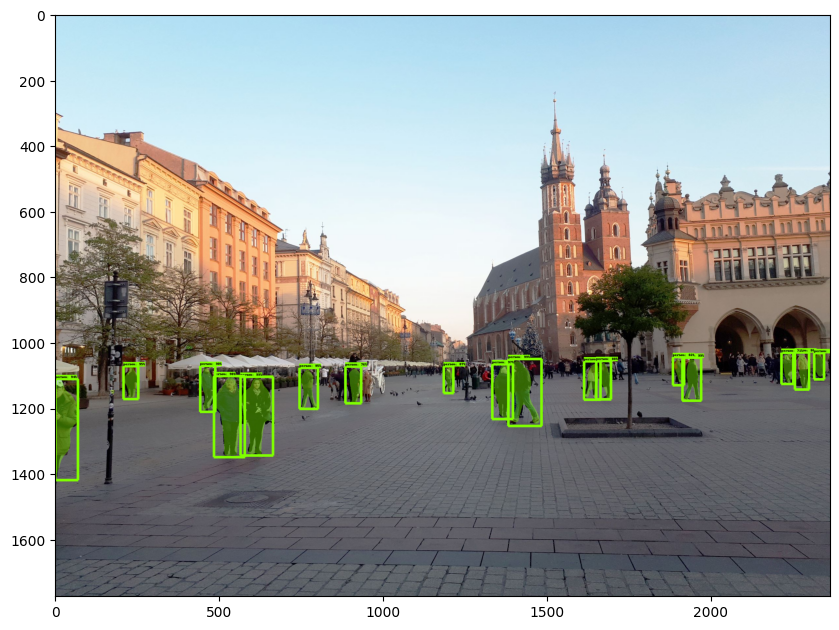

In [23]:
# Handle models with masks:
label_id_offset = 0
image_np_with_mask = image_np.copy()

if 'detection_masks' in result:

  # convert np.arrays to tensors
  detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
  detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

  # reframe the the bounding box mask to the image size.
  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes,
              image_np.shape[1], image_np.shape[2])

  # filter mask pixel values that are above a specified threshold
  detection_masks_reframed = tf.cast(detection_masks_reframed > 0.6,
                                      tf.uint8)

  # get the numpy array
  result['detection_masks_reframed'] = detection_masks_reframed.numpy()

# overlay labeled boxes and segmentation masks on the image
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_mask[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,
      min_score_thresh=.70,
      agnostic_mode=False,
      instance_masks=result.get('detection_masks_reframed', None),
      line_thickness=8)

plt.figure(figsize=(10, 15))
plt.imshow(image_np_with_mask[0])
plt.savefig('prague_segmented.png')
plt.show()

#**Author & Last Updated**

In [24]:
from datetime import datetime, timedelta

current_time = datetime.now()
modified_time = current_time + timedelta(hours=5, minutes=30)

modified_time_str = modified_time.strftime('%Y-%m-%d %I:%M:%S %p')

print(f"Changes have been made to the project on {modified_time_str}")

Changes have been made to the project on 2024-05-15 11:09:02 PM


**Chaudhari Dhairyansh Nathubhai**

**M.Tech, Computer Engineering, National Institute Of Technology Kurukshetra**
